In [1]:
import sys
from datetime import datetime, timezone, timedelta
import torch as th
from stable_baselines3 import DQN

sys.path.append("../airflow/plugins")
sys.path.append("../risk-engine")

from db_connection import DbConnection
from domain_model import Instrument, Interval
from gym_env_single_asset import register_single_asset_trading_env, Actions
from moex_candles_sql_adapter import CandlesSqlAdapter
from strategy_basic import StrategyRandomWalk, StrategyTrendFollowing
from strategy_sb3 import StrategySb3
from evaluation.strategy_evaluator import StrategyEvaluator
from portfolio import Portfolio


In [2]:
register_single_asset_trading_env(1)
db_connection = DbConnection.local_db_connection()
instrument = Instrument.get_instrument("SBER")
interval = Interval.min_10
device = th.device("cuda" if th.cuda.is_available() else "cpu")
sql_adapter = CandlesSqlAdapter(db_connection, interval, instrument)

Environment registered. EnvSpec(id='SingleAssetTrading-v1', entry_point='gym_env_single_asset:SingleAssetTrading', reward_threshold=None, nondeterministic=False, max_episode_steps=None, order_enforce=True, autoreset=False, disable_env_checker=True, apply_api_compatibility=False, kwargs={}, namespace=None, name='SingleAssetTrading', version=1, additional_wrappers=(), vector_entry_point=None)


In [3]:
start_time_utc = datetime(2024, 12, 24, 6, 0, 0, tzinfo=timezone.utc)
end_time_utc = datetime(2024, 12, 28, 21, 0, 0, tzinfo=timezone.utc)
#start_time_utc = end_time_utc - timedelta(days=60)
quantity_lots = 10
lot_size = instrument.lot_size
initial_balance = 100000

In [4]:
model = DQN.load("models/dqn_model.zip")
sb3_strategy = StrategySb3(model)
s3_evaluator = StrategyEvaluator(sql_adapter, sb3_strategy)
sb3_df_ops = s3_evaluator.get_operations(start_time_utc, end_time_utc, quantity_lots, lot_size)
#sb3_df_ops

<Axes: >

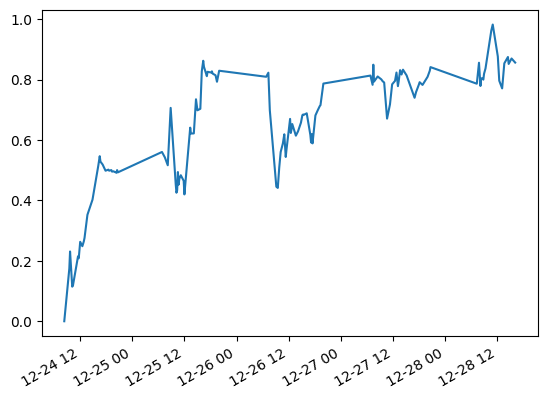

In [5]:
sb3_df_yield = Portfolio.get_yield_from_operations(sb3_df_ops, initial_balance=initial_balance)

sb3_df_yield["yield"].plot()

In [8]:
avg_yield = sb3_df_yield['yield'].mean()
daily_yield = avg_yield / 4
annual_yield =  daily_yield * 248
print(f'Annual yield:{annual_yield}')

Annual yield:39.883197080295695


<Axes: >

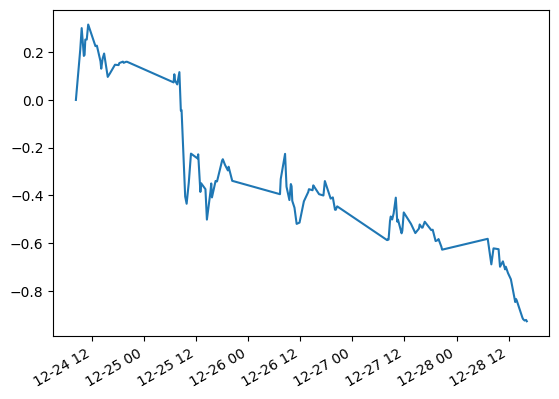

In [7]:
rw_strategy = StrategyRandomWalk()
rw_evaluator = StrategyEvaluator(sql_adapter, rw_strategy)
rw_df_ops = rw_evaluator.get_operations(start_time_utc, end_time_utc, quantity_lots, lot_size)
rw_df_yield = Portfolio.get_yield_from_operations(rw_df_ops, initial_balance=initial_balance)
rw_df_yield["yield"].plot()

<Axes: >

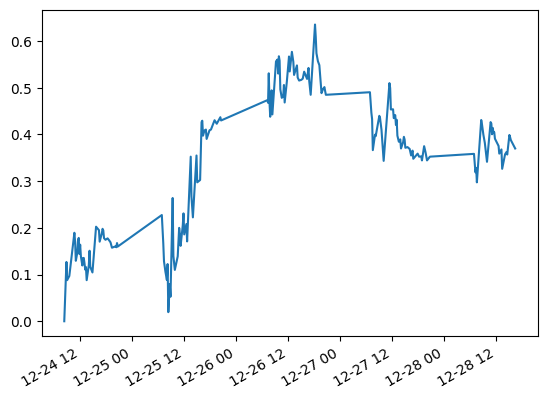

In [9]:
from feature_composer import FeatureComposer
from gym_env_single_asset import SingleAssetTrading
feature_composer = FeatureComposer(sql_adapter, fill_missing_values=False)
candles = feature_composer.compose(start_time_utc, end_time_utc)
threshold = SingleAssetTrading.get_threshold(candles)

tf_strategy = StrategyTrendFollowing(price_delta_threshold=threshold)
tf_evaluator = StrategyEvaluator(sql_adapter, tf_strategy)
tf_df_ops = tf_evaluator.get_operations(start_time_utc, end_time_utc, quantity_lots, lot_size)
tf_df_yield = Portfolio.get_yield_from_operations(tf_df_ops, initial_balance=initial_balance)
tf_df_yield["yield"].plot()

In [10]:
sb3_df_yield.rename(columns={"yield": "DQN"}, inplace=True)
sb3_df = sb3_df_yield[["DQN"]]


In [11]:
rw_df_yield.rename(columns={"yield": "random_walk"}, inplace=True)
rw_df = rw_df_yield[["random_walk"]]


In [12]:
tf_df_yield.rename(columns={"yield": "trend_follow"}, inplace=True)
tf_df = tf_df_yield[["trend_follow"]]


In [13]:
#benchmark = candles.join([sb3_df, tf_df], sort=True)
benchmark = candles.join([sb3_df, rw_df, tf_df], sort=True)
benchmark = benchmark[['DQN',  'random_walk', 'trend_follow']]
#benchmark = benchmark[['DQN',  'trend_follow']]
benchmark.ffill(inplace=True)
#benchmark

<Axes: title={'center': 'Относительная доходность стратегий (%)'}, xlabel='time_utc'>

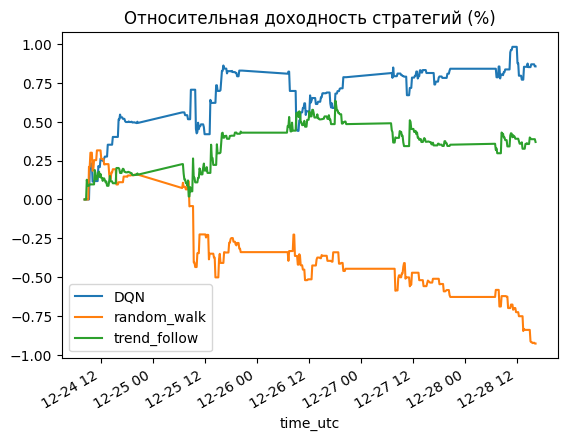

In [14]:
benchmark.plot(title="Относительная доходность стратегий (%)")